Finding effective adversarial bias field for data augmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import math
import torch

from utils import get_unet_model
from adv_bias import AdvBias
from utils import _disable_tracking_bn_stats,set_grad
from adv_compose_solver import ComposeAdversarialTransformSolver

%matplotlib inline

1. 1 Load data

In [2]:
image_path ='./data/img.nrrd'
label_path ='./data/seg.nrrd'

slice_id = 7
image = sitk.GetArrayFromImage(sitk.ReadImage(image_path))[slice_id]
label = sitk.GetArrayFromImage(sitk.ReadImage(label_path))[slice_id]

print ('image size:',image.shape)
print ('label size:',label.shape)



image size: (271, 228)
label size: (271, 228)


1.2 Preprocessing data

In [3]:
## central crop them to [128,128]
crop_size =(128,128)
h_diff = (image.shape[0]-crop_size[0])//2
w_diff = (image.shape[1]-crop_size[1])//2

cropped_image = image[h_diff:crop_size[0]+h_diff,w_diff:crop_size[1]+w_diff]
cropped_label = label[h_diff:crop_size[0]+h_diff,w_diff:crop_size[1]+w_diff]

cropped_label[cropped_label==1]=0
cropped_label[cropped_label==3]=0


# rescale image intensities to 0-1
cropped_image = (cropped_image-cropped_image.min())/(cropped_image.max()-cropped_image.min()+1e-10)
cropped_image.shape




(128, 128)

(-0.5, 127.5, 127.5, -0.5)

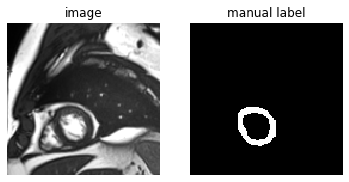

In [4]:
font_size=12
plt.subplot(121)
plt.title('image',size=font_size)
plt.imshow(cropped_image,cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(cropped_label,cmap='gray')
plt.title('manual label',size=font_size)
plt.axis('off')


2.1 Load a segmentation model

In [5]:
use_gpu=True
model = get_unet_model(num_classes=2,model_path='./saved_checkpoints/myo_seg_unet_16.pth',model_arch='UNet_16')

if use_gpu: model = model.cuda()
model.eval()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32

(-0.5, 127.5, 127.5, -0.5)

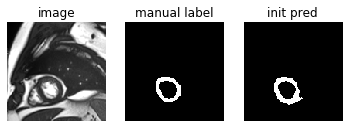

In [6]:
image_tensor = torch.from_numpy(cropped_image[np.newaxis,np.newaxis,:,:]).float()
if use_gpu: image_tensor = image_tensor.cuda()
image_tensor.requires_grad=False
with torch.no_grad():
    init_output = model(image_tensor)
pred_map = init_output.max(1)[1].cpu().data.numpy()

plt.subplot(131)
plt.title('image',size=font_size)
plt.imshow(cropped_image,cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(cropped_label,cmap='gray')
plt.title('manual label',size=font_size)
plt.axis('off')
plt.subplot(133)
plt.imshow(pred_map[0],cmap='gray')
plt.title('init pred',size=font_size)
plt.axis('off')

2.1 set up adversarial bias field adversarial 

In [7]:
augmentor_bias= AdvBias(
                 config_dict={'epsilon':0.3,
                 'control_point_spacing':[crop_size[0]//4,crop_size[1]//4],
                 'downscale':2,
                 'data_size':(1,1,crop_size[0],crop_size[1]),
                 'interpolation_order':3,
                 'init_mode':'random',
                 'space':'log'},debug=False)

                 



  


Perform random bias field augmentation

(-0.5, 127.5, 127.5, -0.5)

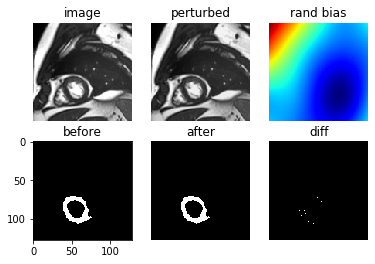

In [8]:
augmentor_bias.init_parameters()
rand_biased_image_tensor = augmentor_bias.forward(image_tensor) 
rand_pred_map = model(rand_biased_image_tensor.detach().clone()).max(1)[1].cpu().data.numpy()
perturbed_image =rand_biased_image_tensor.cpu().numpy()[0,0]
rand_bias= augmentor_bias.bias_field.cpu().numpy()[0,0]
plt.subplot(231)
plt.title('image',size=font_size)
plt.axis('off')
plt.imshow(cropped_image,cmap='gray')
plt.subplot(232)
plt.title('perturbed',size=font_size)
plt.axis('off')
plt.imshow(perturbed_image,cmap='gray')
plt.subplot(233)
plt.title('rand bias',size=font_size)
plt.axis('off')
plt.imshow(rand_bias,cmap='jet')
plt.subplot(234)
plt.imshow(pred_map[0],cmap='gray')
plt.title('before',size=font_size)
plt.subplot(235)
plt.imshow(rand_pred_map[0],cmap='gray')
plt.title('after',size=font_size)
plt.axis('off')
plt.subplot(236)
plt.imshow(abs(rand_pred_map[0]-pred_map[0]),cmap='gray')
plt.title('diff',size=font_size)
plt.axis('off')


In [9]:
## apply adversarial training to find effective bias field
solver = ComposeAdversarialTransformSolver(
        chain_of_transforms=[augmentor_bias],
        divergence_types = ['kl','contour'], ### you can also change it to 'mse' for mean squared error loss
        
        divergence_weights=[1.0,0.5],
        use_gpu= True,
        debug=True,
       )

## 4. start learning
solver.init_random_transformation()
rand_transformed_image = solver.forward(image_tensor.detach().clone())
rand_predict = model.forward(rand_transformed_image)
rand_bias = augmentor_bias.bias_field

model.zero_grad()
## 4.2 adv data augmentation 
loss = solver.adversarial_training(
        data=image_tensor,model=model,
        n_iter=1,
        lazy_load=[True], ## if set to true, it will use the previous sampled random bias field as initialization.
        optimize_flags=[True],power_iteration=False)

adv_bias= augmentor_bias.bias_field

adv_transformed_image = solver.forward(image_tensor.detach().clone())

adv_predict = model.forward(adv_transformed_image)




[True]
kl:2.94606124953134e-05
contour:0.00011568201443878934
0 inner loop: dist 8.730161789571866e-05
update bias parameters
kl:0.07275141775608063
contour:0.09945134073495865
outer loop loss tensor(0.1225, device='cuda:0', grad_fn=<DivBackward0>)
init out torch.Size([1, 2, 128, 128])


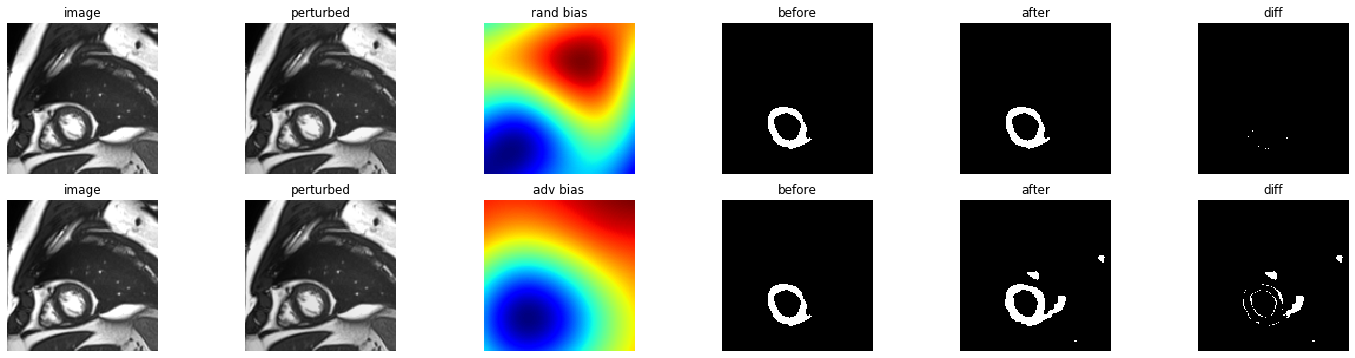

In [10]:
rand_transformed_image_numpy=rand_transformed_image.cpu().data.numpy()[0,0]
adv_transformed_image_numpy=adv_transformed_image.cpu().data.numpy()[0,0]

rand_predict_numpy=rand_predict.max(1)[1].cpu().data.numpy()[0]
adv_predict_numpy=adv_predict.max(1)[1].cpu().data.numpy()[0]


rand_bias_numpy=rand_bias.cpu().data.numpy()[0,0]
adv_bias_numpy=adv_bias.cpu().data.numpy()[0,0]

plt.figure(figsize=(20,10))
plt.subplot(461)
plt.title('image',size=font_size)
plt.axis('off')
plt.imshow(cropped_image,cmap='gray')
plt.subplot(462)
plt.title('perturbed',size=font_size)
plt.axis('off')
plt.imshow(rand_transformed_image_numpy,cmap='gray')
plt.subplot(463)
plt.imshow(rand_bias_numpy,cmap='jet')
plt.title('rand bias',size=font_size)
plt.axis('off')

plt.subplot(464)
plt.title('before',size=font_size)
plt.axis('off')
plt.imshow(pred_map[0],cmap='gray')
plt.subplot(465)
plt.title('after',size=font_size)
plt.axis('off')
plt.imshow(rand_predict_numpy,cmap='gray')
plt.subplot(466)
plt.imshow(abs(rand_predict_numpy-pred_map[0]),cmap='gray')
plt.title('diff',size=font_size)
plt.axis('off')


plt.subplot(467)
plt.title('image',size=font_size)
plt.axis('off')
plt.imshow(cropped_image,cmap='gray')
plt.subplot(468)
plt.title('perturbed',size=font_size)
plt.axis('off')
plt.imshow(adv_transformed_image_numpy,cmap='gray')
plt.subplot(469)
plt.imshow(adv_bias_numpy,cmap='jet')
plt.title('adv bias',size=font_size)
plt.axis('off')
## results with adv bias field

plt.subplot(4,6,10)
plt.title('before',size=font_size)
plt.axis('off')
plt.imshow(pred_map[0],cmap='gray')
plt.subplot(4,6,11)
plt.title('after',size=font_size)
plt.axis('off')
plt.imshow(adv_predict_numpy,cmap='gray')
plt.subplot(4,6,12)
plt.imshow(abs(adv_predict_numpy-pred_map[0]),cmap='gray')
plt.title('diff',size=font_size)
plt.axis('off')
plt.tight_layout()




In [11]:
## now you can simply learn effective adversarial bias fields on-the-fly to enhance training. a sample code will be like the following
## pseudo code for model optimization at one iteration: 
solver = ComposeAdversarialTransformSolver(
        chain_of_transforms=[augmentor_bias],
        divergence_types = ['kl','contour'], ### you can also change it to 'mse' for mean squared error loss
        divergence_weights=[1.0,0.5],
        use_gpu= True,
        debug=False, ## turn off debugging information
       )

## unsupervised consistency loss
model.train()
init_output = model(image_tensor)
reg_loss = solver.adversarial_training(
        data=image_tensor,model=model, init_output=init_output.detach.clone(),
        n_iter=1,
        lazy_load=[False], 
        optimize_flags=[True],power_iteration=False)

## you can add it with the your original supervised loss (if have one). Below is a demo code for reference, do not run it.
model.train()
model.zero_grad()
supervised_loss = loss (init_output,label)
lamda=1
total_loss =supervised_loss+lamda*reg_loss
total_loss.backward()
optimizer.step() 



AttributeError: 'builtin_function_or_method' object has no attribute 'clone'